# Calculate Landuse Availabilities

This example shows how `atlite` can deal with landuse restrictions. The script is adjusted from the excellent `atlite` examples that can be found here https://github.com/PyPSA/atlite/tree/master/examples

In [1]:
import atlite
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

import os
import sys
sys.path.append('../')  # to import helpers
from scripts._helpers import sets_path_to_root
sets_path_to_root("pypsa-africa")


# IMPORTANT: RUN SCRIPT FROM THIS SCRIPTS DIRECTORY i.e data_exploration/ TODO: make more robust
# os.chdir(os.path.dirname(os.path.abspath(__file__)))
sys.path.append("./../scripts")

plt.rcParams['figure.figsize'] = [7, 7]

This is the repository path:  /home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/pypsa-africa
Had to go 1 folder(s) up.


With `geopandas` we retrieve the geographic shapes (in vector format) for Nigeria and Niger.

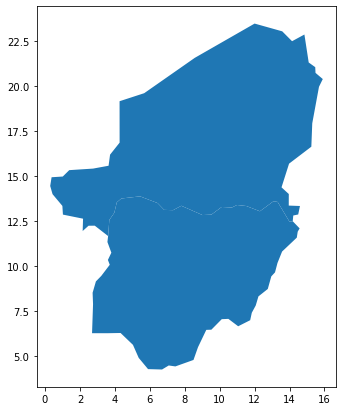

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world.query('continent == "Africa"')
countries = ["Nigeria", "Niger"]
shapes = world[world.name.isin(countries)].set_index('name')

# For showing cutouts in Africa
# shapes = africa
shapes.plot();

We create an `atlite.Cutout` which covers the whole regions and builds the backbone for our analysis. Later, it will enable to retrieve the needed weather data. 

In [3]:
existing_cutout_path = os.path.realpath("cutouts")+"/africa-2013-era5"  # data for whole Africa
bounds = shapes.cascaded_union.buffer(1).bounds
cutout = atlite.Cutout(existing_cutout_path, module='era5', bounds=bounds, time=slice('2013-01-01', '2013-01-02'))

/tmp/ipykernel_579255/1140203528.py:2: FutureWarning: The 'cascaded_union' attribute is deprecated, use 'unary_union' instead
  bounds = shapes.cascaded_union.buffer(1).bounds
/home/max/anaconda3/envs/pypsa-africa/lib/python3.9/site-packages/atlite/cutout.py:179: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(


Let's see how the grid cells and the regional shapes overlap. 

KeyboardInterrupt: 

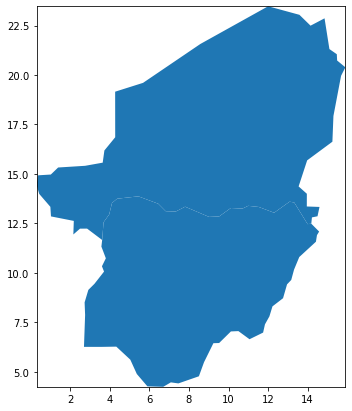

In [4]:
fig, ax = plt.subplots(figsize=(7,7))

# Plotting requirements
xlim = [shapes.total_bounds[0], shapes.total_bounds[2]]
ylim = [shapes.total_bounds[1], shapes.total_bounds[3]]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

shapes.plot(ax=ax)
cutout.grid.plot(ax=ax, edgecolor='grey', color='None')

## Dataset to constraint the availbility

The following dataset is here applied containing forest rasters in Africa (and many more things).

- Copernicus Global Land Service Dataset refered in the following as Copernicus data

Marcel Buchhorn, Bruno Smets, Luc Bertels, Bert De Roo, Myroslava Lesiv, Nandin-Erdene Tsendbazar, Martin Herold, & Steffen Fritz. (2020). Copernicus Global Land Service: Land Cover 100m: collection 3: epoch 2018: Globe (V3.0.1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.3518038
Contains 23 classes from forests to build area. 

In [ ]:
def download_copernicus(update=False, out_logging=True):
    """
    Download copernicus (land coverage data) tiff file from zenodo: https://zenodo.org/record/3518038#.YRGtMjoo_mE
    The file will be stored in ~/pypsa-africa/data/landcover as `PROBAV_LC100_global_v3.0.1_2018-conso_Forest-Type-layer_EPSG-4326.tif`

    Parameters
    ----------
    update : bool 
        Update = true, forces re-download of files

    """
    input_file = "PROBAV_LC100_global_v3.0.1_2018-conso_Forest-Type-layer_EPSG-4326.tif"
    copernicus_url = "https://zenodo.org/record/3518038/files/PROBAV_LC100_global_v3.0.1_2018-conso_Forest-Type-layer_EPSG-4326.tif?download=1"

    input_filepath = os.path.join(
        os.getcwd(), "data", "raw", "landcover", input_file
    )

    if not os.path.exists(input_filepath) or update is True:
        if out_logging:
            print(f"{input_file} does not exist, downloading to {input_filepath}")
        #  create data/osm directory
        os.makedirs(os.path.dirname(input_filepath), exist_ok=True)

        with requests.get(copernicus_url, stream=True) as r:
            with open(input_filepath, "wb") as f:
                shutil.copyfileobj(r.raw, f)
    
    return

# download_copernicus()

The [Copernicus Global Land Service](https://zenodo.org/record/3518038#.YRIbFToo-EB) database provides a global 100 m x 100 m raster which, for each raster cell, indicates the type of landuse (forest, urban, industrial). In total there are 23 classes.

For calculating the availability per cutout weather cells, an `ExclusionContainer` must be defined beforehand. It serves as a container for all rasters and geometries we want to exclude (or possibly include). 

In many cases, rasters and geometries have different projections and resolutions. Therefore, the `ExclusionContainer` is initialized by a CRS and a resolution which suits as a basis for all added rasters and geometries. Per default the CRS is 3035 and the resoultion 100, which leads set a raster of 100 meter resolution. All rasters and geometries will be converted to this `(crs, res)` config if they don't match it. 

Some extra functionality which needs to be adjusted for the Copernicus data:
When adding a raster to the `ExclusionContainer` you can specify which codes (integers) to exclude. 
By setting `invert=True`, you can also restrict the **inclusion** to a set of codes. Further you can buffer around codes (see the docs for detail). Here we are going to exclude the first twenty landuse codes. 

In [5]:
# Data = Forest Type Layer (0-5)
input_file = "PROBAV_LC100_global_v3.0.1_2018-conso_Forest-Type-layer_EPSG-4326.tif"
input_filepath = os.path.join(
    os.getcwd(), "data", "raw", "landcover", input_file
)
CORINE = input_filepath
excluder = ExclusionContainer()
excluder.add_raster(CORINE)

For the demonstration we want to see how the landuse availability behaves within one specific shape, e.g. Nigeria. 

Note that, since the excluder is in `crs=3035`, we convert to geometry of Nigeria to `excluder.crs` for plotting it...

In [6]:
nigeria = shapes.loc[['Nigeria']].geometry.to_crs(excluder.crs)
masked, transform = shape_availability(nigeria, excluder)

...and use the `shape_availability` function of `atlite` to calculate a mask for the `ExclusionContainer` excluder. 

In [7]:
eligible_share = masked.sum() * excluder.res**2 / nigeria.geometry.item().area

The `masked` object is a numpy array. Eligile raster cells have a 1 and excluded cells a 0. Note that this data still lives in the projection of `excluder`. We use the `rasterio.plot.show` function for plotting

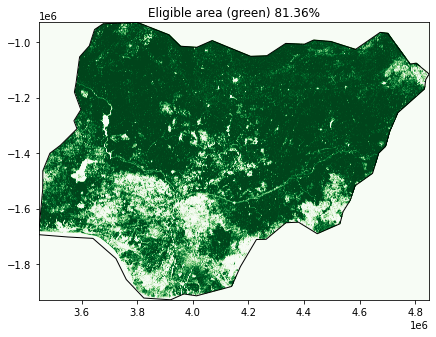

In [8]:
fig, ax = plt.subplots()
ax = show(masked, transform=transform, cmap='Greens', ax=ax)
nigeria.plot(ax=ax, edgecolor='k', color='None')
ax.set_title(f'Eligible area (green) {eligible_share * 100:2.2f}%');

How does is look when we add our cutout grid to the plot? How do the weather cells intersect with the available area? 

In [ ]:
fig, ax = plt.subplots()

# Plotting requirements
xlim = [shapes.total_bounds[0], shapes.total_bounds[2]]
ylim = [shapes.total_bounds[1], shapes.total_bounds[3]]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = show(masked, transform=transform, cmap='Greens', ax=ax)
nigeria.plot(ax=ax, edgecolor='k', color='None')
cutout.grid.to_crs(excluder.crs).plot(edgecolor='grey', color='None', ax=ax, ls=':')
ax.set_title(f'Eligible area (green) {eligible_share * 100:2.2f}%');

We see that the weather cells are much larger than the raster cells. `GDAL` provides a fast reprojection function for averaging fine-grained to coarse-grained rasters. `Atlite` automates this calculation for all geometries in `shapes` when calling the `cutout.availabilitymatrix` function. Let's see how this function performs. (Note that the steps before are not necessary for this calculation.)

**INFO**: *For large sets of shapes set nprocesses to a number > 1 for parallelization.*

In [12]:
A = cutout.availabilitymatrix(shapes, excluder)
A

Compute availability matrix:   0%|                | 0/2 [00:00<?, ? gridcells/s]IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
Compute availability matrix:  50%|████    | 1/2 [00:37<00:37, 37.33s/ gridcells]IllegalArgumentException: Geometry must be a Point or LineSt

<xarray.DataArray (name: 2, y: 257, x: 291)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * name     (name) object 'Niger' 'Nigeria'
  * y        (y) float64 -37.5 -37.2 -36.9 -36.6 -36.3 ... 38.4 38.7 39.0 39.3
  * x        (x) float64 -19.5 -19.2 -18.9 -18.6 -18.3 ... 66.6 66.9 67.2 67.5

`A` is an DataArray with 3 dimensions (`shape`, `x`, `y`) and very sparse data. It indicates the relative overlap of weather cell `(x, y)` with geometry `shape` while excluding the area specified by the `excluder`. 

How does the availability look for our example of Nigeria?

KeyboardInterrupt: 

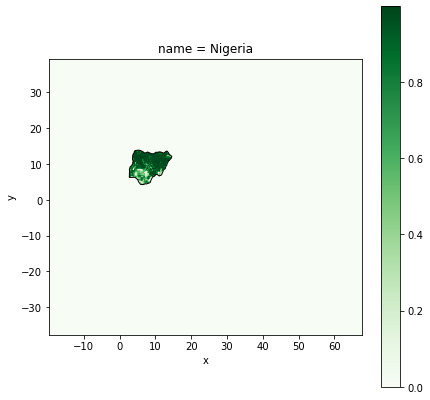

In [13]:
# TODO: Plot worked however was somehow scaled to Africa

fig, ax = plt.subplots(figsize=(7,7))

# Plotting requirements
xlim = [shapes.total_bounds[0], shapes.total_bounds[2]]
ylim = [shapes.total_bounds[1], shapes.total_bounds[3]]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

A.sel(name='Nigeria').plot(cmap='Greens')
shapes.loc[['Nigeria']].plot(ax=ax, edgecolor='k', color='None')
cutout.grid.to_crs(excluder.crs).plot(ax=ax, color='None', edgecolor='grey', ls=':')

Note that now the projection is in `cutout.crs`. In the south, where most of the areas were excluded, the availability is lower than 0.5. That means less than the half of these weather cells and their potentials can be exploited. 